# Sentence classification

The task is: given vacancy text in a format of list
 of sentences. Classifier should predict either given sentence contains requirements
 for the applicant (class 1) or not (class 0).
 12k sentences from the list of vacancies were labeled by efforts of Danya Lyakhov.
 He used active learning approach to label sentences faster: he was choosing basis sentences which was clearly
 belong certain class and then was clustering sentences using Bert model embeddings as feature to cluster.
 After that he was taking certain amount of similar sentences (usually 300) and was manually checking
 is this sentences contains working demands or not.
 Usually almost all the similar sentences were the same class, but some outlayers were filtered manually.
 Besides, dataset contains only working conditions description was found and used as
 set of sentences with class 0 (not contains requirements).

In [274]:
!pip install pandas nltk bokeh numpy gensim -q

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext tensorboard

In [2]:
path = './jp.csv'
df = pd.read_csv(path)

## Watch data a bit

In [3]:
df

,Unnamed: 0,sentence,label,score
0,0,Solid Knowledge of statistical analysis (regre...,1.0,0.818636
1,1,Drive actions at scale using scientifically-ba...,1.0,0.806346
2,2,"Candidate must be a self-starting, highly moti...",1.0,1.000000
3,3,)..Experience with cloud technologies and AWS....,1.0,0.812862
4,4,Is familiar with disciplines such as Natural L...,1.0,0.563148
...,...,...,...,...
24774,24774,Minimum 1 year of experience in a correspondin...,1.0,0.000000
24775,24775,- University degree in Computer Sciences or a ...,1.0,0.000000
24776,24776,Experience should include writing complex quer...,1.0,0.000000
24777,24777,NET Framework and ADO.NET; - Knowledgeof Web S...,1.0,0.000000


In [4]:
df.sentence[df.label == 2.].iloc[2]

"\n\nStrategy\n\nIBC maintains a decentralized structure in which local advisory boards, made up of members of the communities in the bank is located, direct operations of its branches, including recruiting prospective clients and developing products and services to meet local customers' needs  "

Let's check class distribution (looks really balanced!)

In [5]:
first_class_num = len(df[df.label == 1.0]) 
second_class_num = len(df[df.label == 2.0])
sum_num = len(df[df.label.isin([1.0, 2.0])])
print(f'class 0 num: {first_class_num}, class 1 num {second_class_num}, total: {first_class_num + second_class_num}, 0 + 1: {first_class_num + second_class_num}, 1 / 0: {first_class_num / second_class_num}')

class 0 num: 12813, class 1 num 11966, total: 24779, 0 + 1: 24779, 1 / 0: 1.070783887681765


Tokenization

In [6]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

tokenized_sentences = []
for sentence in df.sentence:
    tokenized_sentences.append(tokenizer.tokenize(sentence.lower()))

In [7]:
tokenized_sentences[125]

['the',
 'ideal',
 'candidate',
 'will',
 'have',
 'strong',
 'experience',
 'with',
 'python',
 'as',
 'well',
 'as',
 'strong',
 'oral',
 'and',
 'written',
 'communication',
 'skills',
 '.']

## Words frequency distribution analisys

In [8]:
flatten_ts = [word for sentence in tokenized_sentences for word in sentence]

In [9]:
from collections import Counter

counter = Counter(flatten_ts)
distr = [(k, v) for k, v in sorted(counter.items(), key=lambda x: x[1])]

Let's find less and most popular words

In [10]:
# Least popular words
least_popular_words = [ word for word, pop in distr if pop  < 5]
least_popular_words[:20], len(least_popular_words)

(['problemsdemonstrated',
  'performanceintellectual',
  'bigsql',
  'preferredstrong',
  'agronomists',
  'anthropology',
  'ch1',
  'jv',
  'defendable',
  'phenomenologies',
  'valuedemonstrated',
  '1213',
  'ebi',
  'frm',
  'standpointbuilding',
  'learningtech',
  'tableauexperience',
  'statisticswe',
  'culturepreferred',
  'solutionability'],
 13960)

In [11]:
# 20 most popular words
distr[-20:]

[('skills', 8213),
 ('is', 8739),
 ('/', 9684),
 ('for', 9894),
 ('or', 9963),
 ('knowledge', 10799),
 ('data', 12850),
 ('..', 14439),
 ('experience', 17490),
 ('a', 18461),
 ('with', 19030),
 ('the', 26688),
 ('in', 28206),
 ('.', 28259),
 ('to', 32751),
 ('of', 35437),
 (';', 38347),
 ('-', 61423),
 ('and', 75117),
 (',', 79681)]

In [12]:
# Word frequency distribution
counts = Counter(list(counter.values()))
counts = {k: v for k, v in sorted(counts.items(), key=lambda x: x[0], reverse=True)}

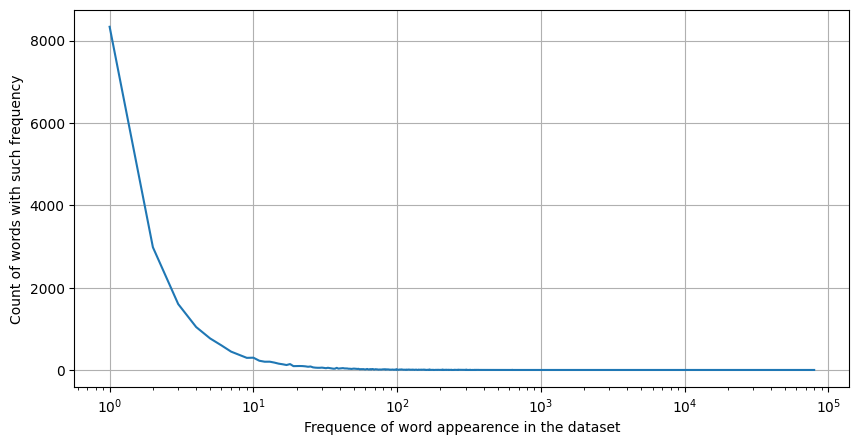

In [14]:
# Word frequency distribution visualized
frequency = list(counts.keys())
count_of_words_with_such_frequency = list(counts.values())
plt.plot(frequency, count_of_words_with_such_frequency) # x, y

plt.xscale('log')
plt.xlabel('Frequence of word appearence in the dataset')
plt.ylabel('Count of words with such frequency')
plt.grid()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

plt.show()

## PLAN

* data cleaning, at least 5 times including in text (expirience is data specific word - do not delete)
    delete punctuations, pronouns, articles + lemitization + (steming) - KP
* Word2Vec learning - KP
* graphics and statistics (data count vs frequency in all sentences), bar plots with word frequency, top50 most popular and top50 least popular - DL
* aggragate words in sentences (average, based on most popular words average them with diff weight) - KP
* classical ML, 4 algorithms. 1) logistic regression - DL 2) SVM - KP 3) random trees - DL 4) knn + PCA - KP + graphics + hyperparam
* NN (linear NN - KP, CNN - KP + DL, NLP transformer - DL, (LSTM))+ hyperparam tuning + tensorboard graphics
* conclusion - KP + DL

## Data cleaning

We will remove punctoation, emoji, URLs and stop words

In [15]:
import re
cleaned_sentences = df.sentence.apply(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))
cleaned_sentences.head()

0    Solid Knowledge of statistical analysis regres...
1    Drive actions at scale using scientificallybas...
2    Candidate must be a selfstarting highly motiva...
3    Experience with cloud technologies and AWSStro...
4    Is familiar with disciplines such as Natural L...
Name: sentence, dtype: object

let's the sentence from above to compare!

In [16]:
# Before
df[df.label == 2.].sentence.iloc[2]

"\n\nStrategy\n\nIBC maintains a decentralized structure in which local advisory boards, made up of members of the communities in the bank is located, direct operations of its branches, including recruiting prospective clients and developing products and services to meet local customers' needs  "

In [17]:
# After
cleaned_sentences[df.label == 2.].iloc[2]

'StrategyIBC maintains a decentralized structure in which local advisory boards made up of members of the communities in the bank is located direct operations of its branches including recruiting prospective clients and developing products and services to meet local customers needs  '

Removing stop words

In [18]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
cleaned_stops = cleaned_sentences.apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dlyakhov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# let's see the same sentence as example
cleaned_stops[df.label == 2.].iloc[2]

'StrategyIBC maintains decentralized structure local advisory boards made members communities bank located direct operations branches including recruiting prospective clients developing products services meet local customers needs'

As we can see we manage to remove all Punctuation, Emoji’s, URL’s, @’s and also stop words in english language!

In [20]:
df['cleaned_sentences'] = cleaned_stops
df.head()

,Unnamed: 0,sentence,label,score,cleaned_sentences
0,0,Solid Knowledge of statistical analysis (regre...,1.0,0.818636,Solid Knowledge statistical analysis regressio...
1,1,Drive actions at scale using scientifically-ba...,1.0,0.806346,Drive actions scale using scientificallybased ...
2,2,"Candidate must be a self-starting, highly moti...",1.0,1.000000,Candidate must selfstarting highly motivated a...
3,3,)..Experience with cloud technologies and AWS....,1.0,0.812862,Experience cloud technologies AWSStrong comput...
4,4,Is familiar with disciplines such as Natural L...,1.0,0.563148,Is familiar disciplines Natural Language Proce...


 Filtered sentences tokenization

In [21]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

tokenized_sentences = []
for sentence in df.cleaned_sentences:
    tokenized_sentences.append(tokenizer.tokenize(sentence.lower()))

In [22]:
tokenized_sentences[4]

['is',
 'familiar',
 'disciplines',
 'natural',
 'language',
 'processing',
 'machine',
 'learning',
 'predictive',
 'modeling',
 'statistical',
 'analysis',
 'hypothesis',
 'testing']

Let's check most / least popular words

In [23]:
flatten_ts = [word for sentence in tokenized_sentences for word in sentence]
counter = Counter(flatten_ts)
distr = [(k, v) for k, v in sorted(counter.items(), key=lambda x: x[1])]
count_threshold = 7
least_popular_words = [word for word, count in distr if count < count_threshold]
print(f'least popular words count: {len(least_popular_words)}')
least_popular_words[:20]

least popular words count: 34158


['performanceintellectual',
 'bigsql',
 'awsstrong',
 'databasestrong',
 'capabilitiesability',
 'cloudstrong',
 'environmentwhen',
 'scientistsa',
 'includesconsulting',
 'biaswriting',
 'reportseffectively',
 'trialsleveraging',
 'handidentifying',
 'processescollaborating',
 'higher3',
 'agronomists',
 'scaleresponsibilitiesbuild',
 'assetsbuild',
 'capabilitiesbuild',
 'productionprepare']

We have chosen 7 as the threshold because words with frequency 8 already have some potential value for classification 

In [24]:
# most poular words
distr[-20:]

[('new', 2891),
 ('develop', 2980),
 ('solutions', 3080),
 ('science', 3205),
 ('learning', 3277),
 ('good', 3588),
 ('strong', 3738),
 ('technical', 3887),
 ('years', 4506),
 ('design', 4669),
 ('team', 4889),
 ('software', 5337),
 ('business', 5525),
 ('ability', 5907),
 ('development', 6457),
 ('skills', 7269),
 ('work', 7569),
 ('knowledge', 10389),
 ('data', 11911),
 ('experience', 14556)]

Looks like all most popular words make clear sense for classification task. But least popular words still contains only outlayers. Let's remove them

In [25]:
sentences_without_rare_words = []
not_popular_words_set = set(least_popular_words)
for sentence in tokenized_sentences:
    filtered_sent = [word for word in sentence if word not in not_popular_words_set]
    sentences_without_rare_words.append(filtered_sent)

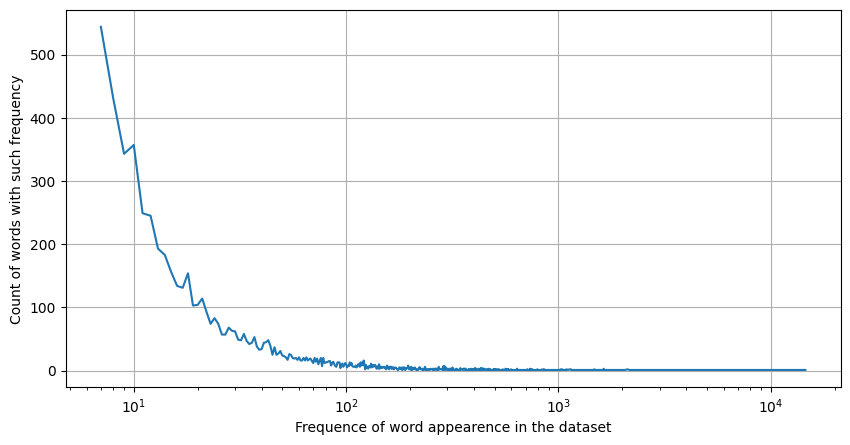

In [26]:
flatten_ts_filtered = [word for sentence in sentences_without_rare_words for word in sentence]
counter = Counter(flatten_ts_filtered)
counts = Counter(list(counter.values()))
counts = {k: v for k, v in sorted(counts.items(), key=lambda x: x[0], reverse=True)}

frequency = list(counts.keys())
count_of_words_with_such_frequency = list(counts.values())
plt.plot(frequency, count_of_words_with_such_frequency) # x, y

plt.xscale('log')
plt.xlabel('Frequence of word appearence in the dataset')
plt.ylabel('Count of words with such frequency')
plt.grid()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

plt.show()

Much more meaningfull words in proportion!

## Lematization 

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/dlyakhov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_output = [[lemmatizer.lemmatize(w) for w in sentence] for sentence in sentences_without_rare_words]
print(len(lemmatized_output))

24779


In [29]:
lemmatized_output[4]

['is',
 'familiar',
 'discipline',
 'natural',
 'language',
 'processing',
 'machine',
 'learning',
 'predictive',
 'modeling',
 'statistical',
 'analysis',
 'hypothesis',
 'testing']

### Word2Vec

In [30]:
from gensim.models import Word2Vec

model = Word2Vec(lemmatized_output, 
                 vector_size=100,# vector_size or size, idk why sometimes you should change param, some pip magic...
                 min_count=5,
                 window=5)

In [31]:
vector = model.wv['computer'] 
vector.shape

(100,)

In [32]:
model.wv.most_similar(["python"])

[('sa', 0.7487086057662964),
 ('pythonexperience', 0.734236478805542),
 ('cc', 0.692768931388855),
 ('matlab', 0.6714930534362793),
 ('java', 0.6650827527046204),
 ('objectoriented', 0.6608738303184509),
 ('skillsdeep', 0.6319075226783752),
 ('qt', 0.6317495107650757),
 ('scala', 0.6289627552032471),
 ('php', 0.6231229305267334)]

In [33]:
y = df.label.values % 2 # [skill class 1 -> 1, backgroud class 2 -> 0]

Compose sentence embeddings like mean of embeddings of words in sentence

In [34]:
# Embedd sentences by mean
X = []
y_filtered = []
for sentence, y_cur in zip(lemmatized_output, y):
    if sentence:
        vectors = np.stack([model.wv.get_vector(word) for word in sentence if word in model.wv.index_to_key])
        sent_emb = np.mean(vectors, axis=0)
        X.append(sent_emb) 
        y_filtered.append(y_cur)
    
X = np.stack(X)
y = np.array(y_filtered)

In [35]:
X.shape, y.shape

((24776, 100), (24776,))

## Machine learning algorithms

# Split dataset

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}')

X_train: 19820, X_test: 4956


In [38]:
len(y[y==0]) / len(y[y==1])

0.9339630005464055

# KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [42]:
pred = neigh.predict(X_test)
report = classification_report(y_true=y_test, y_pred=pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      2393
         1.0       0.97      0.98      0.98      2563

    accuracy                           0.97      4956
   macro avg       0.97      0.97      0.97      4956
weighted avg       0.97      0.97      0.97      4956



# Random trees

In [43]:
from sklearn.ensemble import RandomForestClassifier

RT = RandomForestClassifier(max_depth=5, random_state=42)
RT.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [44]:
pred = RT.predict(X_test)
report = classification_report(y_true=y_test, y_pred=pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2393
         1.0       0.96      0.96      0.96      2563

    accuracy                           0.96      4956
   macro avg       0.96      0.96      0.96      4956
weighted avg       0.96      0.96      0.96      4956



WOOOW!

# Logistig regression

In [45]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

In [46]:
pred = LR.predict(X_test)
report = classification_report(y_true=y_test, y_pred=pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2393
         1.0       0.97      0.97      0.97      2563

    accuracy                           0.97      4956
   macro avg       0.97      0.97      0.97      4956
weighted avg       0.97      0.97      0.97      4956



# ADA BOOOST

In [49]:
from sklearn.ensemble import AdaBoostClassifier

AB = AdaBoostClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)

In [50]:
pred = AB.predict(X_test)
report = classification_report(y_true=y_test, y_pred=pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2393
         1.0       0.97      0.97      0.97      2563

    accuracy                           0.97      4956
   macro avg       0.97      0.97      0.97      4956
weighted avg       0.97      0.97      0.97      4956



Let's try simple exaples to check we are doing right things

In [54]:
sent_1 = "python SQL required"
sent_0 = "you always predict 1?"
sent_00 = "big companies need you"
sent_000 = " Dunkeys likes apples"
sent_0000 = "our comhpany is a fuel enterprise"
sent_11 = "2 years Java expirience"

p = list()
for sent in [sent_1, sent_0, sent_00, sent_000, sent_11]:
    tokens = tokenizer.tokenize(sent.lower())
    input_ = np.stack([model.wv.get_vector(word) for word in sent if word in model.wv.index_to_key])
    input_ = np.mean(input_, axis=0)
    prediction = LR.predict(input_.reshape(1, -1))
    p.append(prediction)
p

[array([1.]), array([0.]), array([0.]), array([0.]), array([1.])]

# SVM + CV scores + grid search

In [88]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
scores

array([0.95885017, 0.95690169, 0.92785612, 0.97367402, 0.98239505])

In [90]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
grid_clf = GridSearchCV(clf, parameters)
grid_clf.fit(X,y)

GridSearchCV(estimator=SVC(C=1, kernel='linear', random_state=42),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [96]:
grid_clf.cv_results_

{'mean_fit_time': array([5.14717336, 5.34242077, 9.54218087, 5.38555226]),
 'std_fit_time': array([0.47932973, 0.45274766, 1.05857718, 0.48143473]),
 'mean_score_time': array([0.69767971, 1.02832489, 0.6651082 , 0.91776667]),
 'std_score_time': array([0.06341811, 0.07842936, 0.05955041, 0.07240529]),
 'param_C': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'}],
 'split0_test_score': array([0.95782889, 0.96711057, 0.95924132, 0.97215496]),
 'split1_test_score': array([0.95620585, 0.96185671, 0.95761857, 0.96811302]),
 'split2_test_score': array([0.92875883, 0.92956609, 0.93118063, 0.93380424]),
 'split

In [97]:
cross_val_score(grid_clf, X, y, cv=5, scoring='f1')

array([0.97283465, 0.96862589, 0.93281442, 0.98245614, 0.98424431])

As we can see the CV csores got higher after grid search. radial kernel with C=10 is better for this task

# DEEEP DEEEEEEP LEARNING


In [39]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter
from torch import optim

In [40]:
class TrainingSchedule:
    def __init__(self,
                 epochs,
                 batch_size,
                 lr,
                 weight_decay,
                 ce_weights,
                 scheduler_gamma,
                 optimizer_type='Adam'):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.ce_weights = ce_weights
        self.scheduler_gamma = scheduler_gamma
        self.optimizer_type = optimizer_type


SENTENCE_TRAINING_SCHEDULE = TrainingSchedule(epochs=150,
                                              batch_size=256,
                                              lr=1e-4,
                                              weight_decay=0.1,
                                              ce_weights=[1, 1],
                                              scheduler_gamma=0.99)

SENTENCE_TRAINING_SCHEDULE_CONV = TrainingSchedule(epochs=150,
                                              batch_size=256,
                                              lr=1e-4,
                                              weight_decay=1e-2,
                                              ce_weights=[1, 1],
                                              scheduler_gamma=0.999)

SCHEDULE = SENTENCE_TRAINING_SCHEDULE_CONV

In [41]:
class ClassificationHead(nn.Module):
    def __init__(self, shape=768, num_classes=2):
        super().__init__()

        self.lin1 = nn.Linear(shape, int(shape / 1.3))
        self.bn1 = nn.BatchNorm1d(int(shape / 1.3))
        self.lin2 = nn.Linear(int(shape / 1.3), int(shape / 2.0))
        self.bn2 = nn.BatchNorm1d(int(shape / 2.0))
        self.lin3 = nn.Linear(int(shape / 2.0), num_classes)
        

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.bn1(x)
        x = F.relu(self.lin2(x))
        x = self.bn2(x)
        x = self.lin3(x)
        return x


In [42]:
def train(train_dataset: TensorDataset,
          val_dataset: TensorDataset,
          device,
          Model,
          validation_freq=10,
          log_dir='logs/'):
    train_dl = DataLoader(train_dataset, batch_size=SCHEDULE.batch_size, shuffle=True)
    model = Model(shape=list(train_dataset[0][0].shape)[0], num_classes=2)
    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(SCHEDULE.ce_weights, dtype=torch.float).to(device))
    optimizer = optim.Adam(model.parameters(), lr=SCHEDULE.lr, weight_decay=SCHEDULE.weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=SCHEDULE.scheduler_gamma)
    writer = SummaryWriter(log_dir)
    model.train()
    for epoch in range(SCHEDULE.epochs):
        running_loss = 0.0
        for xb, yb in train_dl:
            # Zero parameters gradient values
            optimizer.zero_grad()
            # Forward
            outputs = model(xb)
            # Calculate loss
            loss = criterion(outputs, yb)
            # Calculate gradients
            loss.backward()
            # Apply it by optimizer
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        print(f"Epoch: {epoch}, loss: {running_loss}")
        writer.add_scalar('train_loss_per_epoch', running_loss, epoch)
        if (epoch + 1) % validation_freq == 0:
            validate(model, val_dataset, epoch, writer=writer)
            model.train()
        # Change learning rate
        scheduler.step()
    return model

def validate(model, dataset: TensorDataset, epoch, batch_size=64, writer=None):
    test_dl = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    predictions = []
    y_test = []
    with torch.no_grad():
        for xb, yb in test_dl:
            outputs = model(xb)
            predictions.append(torch.argmax(outputs, dim=1).cpu().detach().numpy())
            y_test.append(yb.cpu().detach().numpy())
    predictions = np.concatenate(predictions, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    print(classification_report(y_true=np.array(y_test), y_pred=predictions))
    if writer is not None:
        writer.add_scalar('val_f1', f1_score(y_true=np.array(y_test), y_pred=predictions), epoch)

In [43]:
train_dataset = TensorDataset(torch.tensor(X_train).to("cpu"), torch.tensor(y_train, dtype=torch.long).to("cpu"))
val_dataset = TensorDataset(torch.tensor(X_test).to("cpu"), torch.tensor(y_test, dtype=torch.long).to("cpu"))

In [44]:
train(train_dataset, val_dataset, device="cpu", Model=ClassificationHead, log_dir='logs/fc')

Epoch: 0, loss: 35.614147648215294
Epoch: 1, loss: 14.277611583471298
Epoch: 2, loss: 10.679650224745274
Epoch: 3, loss: 9.261145256459713
Epoch: 4, loss: 8.43599808961153
Epoch: 5, loss: 7.899443984031677
Epoch: 6, loss: 7.4706792533397675
Epoch: 7, loss: 7.221278741955757
Epoch: 8, loss: 6.946083519607782
Epoch: 9, loss: 6.818168085068464
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2393
           1       0.97      0.97      0.97      2563

    accuracy                           0.97      4956
   macro avg       0.97      0.97      0.97      4956
weighted avg       0.97      0.97      0.97      4956

Epoch: 10, loss: 6.569950997829437
Epoch: 11, loss: 6.334330353885889
Epoch: 12, loss: 6.24052195250988
Epoch: 13, loss: 6.059714216738939
Epoch: 14, loss: 5.926858574151993
Epoch: 15, loss: 5.851193118840456
Epoch: 16, loss: 5.633716147392988
Epoch: 17, loss: 5.532610137015581
Epoch: 18, loss: 5.441258177161217
Epoch: 19, loss:

Epoch: 121, loss: 2.0133905755355954
Epoch: 122, loss: 1.8828528923913836
Epoch: 123, loss: 1.947653884999454
Epoch: 124, loss: 1.9419265063479543
Epoch: 125, loss: 1.977925030514598
Epoch: 126, loss: 1.8623382169753313
Epoch: 127, loss: 1.9229771234095097
Epoch: 128, loss: 1.9168511163443327
Epoch: 129, loss: 1.8665386186912656
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2393
           1       0.98      0.98      0.98      2563

    accuracy                           0.98      4956
   macro avg       0.98      0.98      0.98      4956
weighted avg       0.98      0.98      0.98      4956

Epoch: 130, loss: 1.8822525953873992
Epoch: 131, loss: 1.8426471445709467
Epoch: 132, loss: 1.9091075165197253
Epoch: 133, loss: 1.9106288440525532
Epoch: 134, loss: 1.8911975491791964
Epoch: 135, loss: 1.951164540834725
Epoch: 136, loss: 1.771416218020022
Epoch: 137, loss: 1.8318699644878507
Epoch: 138, loss: 1.8393025863915682
Epoch: 139,

ClassificationHead(
  (lin1): Linear(in_features=100, out_features=76, bias=True)
  (bn1): BatchNorm1d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=76, out_features=50, bias=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=50, out_features=2, bias=True)
)

In [46]:
class CNNSimple(nn.Module):
    def __init__(self, shape=768, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(4)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveMaxPool1d(32)
        self.linear = nn.Linear(3072, num_classes)
    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.flatten(start_dim=1)
        x = self.linear(x)
        return x

In [48]:
train(train_dataset, val_dataset, device="cpu", Model=CNNSimple, log_dir='logs/cnn')

Epoch: 0, loss: 13.419572345912457
Epoch: 1, loss: 8.492567971348763
Epoch: 2, loss: 7.958246551454067
Epoch: 3, loss: 7.636468011885881
Epoch: 4, loss: 7.446619540452957
Epoch: 5, loss: 7.275376468896866
Epoch: 6, loss: 7.174264386296272
Epoch: 7, loss: 7.0227404572069645
Epoch: 8, loss: 6.973404984921217
Epoch: 9, loss: 6.835667390376329
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2393
           1       0.97      0.97      0.97      2563

    accuracy                           0.97      4956
   macro avg       0.97      0.97      0.97      4956
weighted avg       0.97      0.97      0.97      4956

Epoch: 10, loss: 6.743496011942625
Epoch: 11, loss: 6.6752699464559555
Epoch: 12, loss: 6.611814117059112
Epoch: 13, loss: 6.542102098464966
Epoch: 14, loss: 6.489353623241186
Epoch: 15, loss: 6.429045747965574
Epoch: 16, loss: 6.3718046471476555
Epoch: 17, loss: 6.354019321501255
Epoch: 18, loss: 6.327311251312494
Epoch: 19, los

Epoch: 122, loss: 5.5592193976044655
Epoch: 123, loss: 5.5158829893916845
Epoch: 124, loss: 5.524767443537712
Epoch: 125, loss: 5.5409882850945
Epoch: 126, loss: 5.549423713237047
Epoch: 127, loss: 5.523346979171038
Epoch: 128, loss: 5.548411039635539
Epoch: 129, loss: 5.515713106840849
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2393
           1       0.98      0.98      0.98      2563

    accuracy                           0.97      4956
   macro avg       0.97      0.97      0.97      4956
weighted avg       0.97      0.97      0.97      4956

Epoch: 130, loss: 5.54141465947032
Epoch: 131, loss: 5.552388995885849
Epoch: 132, loss: 5.5611870512366295
Epoch: 133, loss: 5.5240500420331955
Epoch: 134, loss: 5.54734180867672
Epoch: 135, loss: 5.557878900319338
Epoch: 136, loss: 5.547434829175472
Epoch: 137, loss: 5.562566509470344
Epoch: 138, loss: 5.579606145620346
Epoch: 139, loss: 5.573722183704376
              precision  

CNNSimple(
  (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveMaxPool1d(output_size=32)
  (linear): Linear(in_features=3072, out_features=2, bias=True)
)

In [45]:
%tensorboard --logdir logs --port 6112

# Conclusion

We trained a lot of classical algorithms and CNN and Linear neural networks. With help of cross validation and grid search we achieved high accuracy perfomance on SVM.The most accurate algorithm turn out to be Linear NN with f1 score = 98%. We also computed some statistics and presented tensorboard graphics

